<a href="https://colab.research.google.com/github/madaime2/Novel_Pollen_Phylogenetic_Placement/blob/main/04_Morphological_Visualizations/00_Morphological_Visualizations_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

absolute_path = os.path.dirname("/content/drive/MyDrive/Podocarpus_Final/Podocarpus_Project/")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [114]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
 
torch.manual_seed(3)
data_transforms = {
    'train': transforms.Compose([
       # transforms.RandomResizedCrop(224),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation((-90,90)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
       # transforms.Resize(256),
       torchvision.transforms.Resize((224,224)),
       # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = absolute_path + "/Stacks_Podocarpus_WO_Oleifolius_Train_Val/"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Prepare data to rank individual cross-sectional images according to their phylogenetic informativeness

# Forward-pass individual cross-sectional images to the trained C-CNN

In [115]:
# ResNeXt101, pretrained on imagenet-1K dataset

PATH = absolute_path + "/models/C-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model = models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

from torchvision.transforms.transforms import ConvertImageDtype
from torchvision.transforms.functional import convert_image_dtype
import glob
from PIL import Image

# Forward-pass 
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def extract_features(model, image_dir, k=100):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))

    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    feats = model(images)
    feats = feats.detach().cpu().numpy()

    # Take average and get final prediction
    #feats = feats.mean(0)

    # Add line below to group all cross-sectional features per specimen
    #feats = np.sort(feats, 0)[::-1][:k].mean(0)
    #print(feats.shape)
    return feats

val_dir = absolute_path + "/Oleifolius/Pseudonovel_Stacks_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))

# Modify output
model.fc = nn.Identity()
model.eval()

class_map = {name: idx for idx, name in enumerate(class_names)}
all_image_dirs = []
features = []
labels = []
All_feats_shape = []
for d in val_class_dirs:
  image_dirs = glob.glob(os.path.join(d, '*'))
  for image_dir in image_dirs:
    class_name = os.path.basename(image_dir).split('.')[0]
    #label = class_map[class_name]
    #labels.append(label)
    all_image_dirs.append(image_dir)
    feats = extract_features(model, image_dir)
    features.append(feats)
    All_feats_shape.append(feats.shape)
### Replace by np.stack (vs concatenate) to group all cross-sectional features per specimen
features = np.concatenate(features, 0)
features_Stacks_Indiv = features 

# Forward-pass MIP images to the trained H-CNN

In [116]:
# ResNeXt101, pretrained on imagenet-1K dataset

PATH = absolute_path + "/models/H-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model = models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

from torchvision.transforms.transforms import ConvertImageDtype
from torchvision.transforms.functional import convert_image_dtype
import glob
from PIL import Image

# Forward-pass 
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

def extract_features(model, image_dir, k=100):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))

    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    feats = model(images)
    feats = feats.detach().cpu().numpy()

    # Take average and get final prediction
    #feats = feats.mean(0)

    # Add line below to group all cross-sectional features per specimen
    feats = np.sort(feats, 0)[::-1][:k].mean(0)
    #print(feats.shape)
    return feats

val_dir = absolute_path + "/Oleifolius/Pseudonovel_Images_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))

# Modify output
model.fc = nn.Identity()
model.eval()

class_map = {name: idx for idx, name in enumerate(class_names)}
all_image_dirs = []
features = []
labels = []
for d in val_class_dirs:
  image_dirs = glob.glob(os.path.join(d, '*'))
  for image_dir in image_dirs:
    class_name = os.path.basename(image_dir).split('.')[0]
    #label = class_map[class_name]
    #labels.append(label)
    all_image_dirs.append(image_dir)
    feats = extract_features(model, image_dir)
    features.append(feats)
    
features = np.stack(features, 0)
features_Images_Average = features 

In [117]:
RepeatedImages = []
for i in range(len(All_feats_shape)):
    repeatedImage = torch.tensor(features_Images_Average[i]).repeat(All_feats_shape[i][0],1)
    RepeatedImages.append(repeatedImage)

# Forward-pass patches to the trained P-CNN and average their features

In [118]:
# ResNeXt101, pretrained on imagenet-1K dataset

PATH = absolute_path + "/models/P-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model = models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

from torchvision.transforms.transforms import ConvertImageDtype
from torchvision.transforms.functional import convert_image_dtype
import glob
from PIL import Image

# Forward-pass 
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def extract_features(model, image_dir, k=100):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))

    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    feats = model(images)
    feats = feats.detach().cpu().numpy()

    # Take average and get final prediction
    #feats = feats.mean(0)

    # Add line below to group all cross-sectional features per specimen
    feats = np.sort(feats, 0)[::-1][:k].mean(0)
    #print(feats.shape)
    return feats

val_dir = absolute_path + "/Oleifolius/Pseudonovel_Patches_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))

# Modify output
model.fc = nn.Identity()
model.eval()

class_map = {name: idx for idx, name in enumerate(class_names)}
all_image_dirs = []
features = []
labels = []
for d in val_class_dirs:
  image_dirs = glob.glob(os.path.join(d, '*'))
  for image_dir in image_dirs:
    class_name = os.path.basename(image_dir).split('.')[0]
    #label = class_map[class_name]
    #labels.append(label)
    all_image_dirs.append(image_dir)
    feats = extract_features(model, image_dir)
    features.append(feats)
### Replace by np.stack (vs concatenate) to group all patch features per specimen
features = np.stack(features, 0)
features_Patches_Average = features 

In [119]:
RepeatedPatches = []
for i in range(len(All_feats_shape)):
    repeatedPatch = torch.tensor(features_Patches_Average[i]).repeat(All_feats_shape[i][0],1)
    RepeatedPatches.append(repeatedPatch)

# Concatenate all individual cross-sectional image features (along with the fixed MIP and patch features)


In [120]:
JoinedTensorImages = torch.tensor(torch.cat(RepeatedImages))
JoinedTensorPatches = torch.tensor(torch.cat(RepeatedPatches))
features_Stacks_Indiv_tensor = torch.tensor(features_Stacks_Indiv)
Concatenated_Modalities_Informative_Stacks = torch.cat((features_Stacks_Indiv_tensor,JoinedTensorImages,JoinedTensorPatches),1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Prepare data to rank individual patches according to their phylogenetic informativeness

# Forward-pass individual patches to the trained P-CNN

In [129]:
# ResNeXt101, pretrained on imagenet-1K dataset

PATH = absolute_path + "/models/P-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model = models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

from torchvision.transforms.transforms import ConvertImageDtype
from torchvision.transforms.functional import convert_image_dtype
import glob
from PIL import Image

# Forward-pass 
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def extract_features(model, image_dir, k=100):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))

    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    feats = model(images)
    feats = feats.detach().cpu().numpy()

    # Take average and get final prediction
    #feats = feats.mean(0)

    # Add line below to group all cross-sectional features per specimen
    #feats = np.sort(feats, 0)[::-1][:k].mean(0)
    #print(feats.shape)
    return feats

val_dir = absolute_path + "/Oleifolius/Pseudonovel_Patches_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))

# Modify output
model.fc = nn.Identity()
model.eval()

class_map = {name: idx for idx, name in enumerate(class_names)}
all_image_dirs = []
features = []
labels = []
All_feats_shape = []
for d in val_class_dirs:
  image_dirs = glob.glob(os.path.join(d, '*'))
  for image_dir in image_dirs:
    class_name = os.path.basename(image_dir).split('.')[0]
    #label = class_map[class_name]
    #labels.append(label)
    all_image_dirs.append(image_dir)
    feats = extract_features(model, image_dir)
    features.append(feats)
    All_feats_shape.append(feats.shape)
### Replace by np.stack (vs concatenate) to group all patch features per specimen
features = np.concatenate(features, 0)
features_Patches_Indiv = features 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Forward-pass cross-sectional images to the trained C-CNN and average their features

In [130]:
# ResNeXt101, pretrained on imagenet-1K dataset

PATH = absolute_path + "/models/C-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model = models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

from torchvision.transforms.transforms import ConvertImageDtype
from torchvision.transforms.functional import convert_image_dtype
import glob
from PIL import Image

# Forward-pass 
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def extract_features(model, image_dir, k=100):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))

    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    feats = model(images)
    feats = feats.detach().cpu().numpy()

    # Take average and get final prediction
    #feats = feats.mean(0)

    # Add line below to group all cross-sectional features per specimen
    feats = np.sort(feats, 0)[::-1][:k].mean(0)
    #print(feats.shape)
    return feats

val_dir = absolute_path + "/Oleifolius/Pseudonovel_Stacks_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))

# Modify output
model.fc = nn.Identity()
model.eval()

class_map = {name: idx for idx, name in enumerate(class_names)}
all_image_dirs = []
features = []
labels = []
for d in val_class_dirs:
  image_dirs = glob.glob(os.path.join(d, '*'))
  for image_dir in image_dirs:
    class_name = os.path.basename(image_dir).split('.')[0]
    #label = class_map[class_name]
    #labels.append(label)
    all_image_dirs.append(image_dir)
    feats = extract_features(model, image_dir)
    features.append(feats)
### Replace by np.stack (vs concatenate) to group all patch features per specimen
features = np.stack(features, 0)
features_Stacks_Average = features 

In [131]:
RepeatedStacks = []
for i in range(len(All_feats_shape)):
    repeatedStack = torch.tensor(features_Stacks_Average[i]).repeat(All_feats_shape[i][0],1)
    RepeatedStacks.append(repeatedStack)

# Forward-pass MIP images to the trained H-CNN

In [132]:
# ResNeXt101, pretrained on imagenet-1K dataset

PATH = absolute_path + "/models/H-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model = models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

from torchvision.transforms.transforms import ConvertImageDtype
from torchvision.transforms.functional import convert_image_dtype
import glob
from PIL import Image

# Forward-pass 
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

def extract_features(model, image_dir, k=100):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))

    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    feats = model(images)
    feats = feats.detach().cpu().numpy()

    # Take average and get final prediction
    #feats = feats.mean(0)

    # Add line below to group all cross-sectional features per specimen
    feats = np.sort(feats, 0)[::-1][:k].mean(0)
    #print(feats.shape)
    return feats

val_dir = absolute_path + "/Oleifolius/Pseudonovel_Images_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))

# Modify output
model.fc = nn.Identity()
model.eval()

class_map = {name: idx for idx, name in enumerate(class_names)}
all_image_dirs = []
features = []
labels = []
for d in val_class_dirs:
  image_dirs = glob.glob(os.path.join(d, '*'))
  for image_dir in image_dirs:
    class_name = os.path.basename(image_dir).split('.')[0]
    #label = class_map[class_name]
    #labels.append(label)
    all_image_dirs.append(image_dir)
    feats = extract_features(model, image_dir)
    features.append(feats)
    
features = np.stack(features, 0)
features_Images_Average = features 

In [133]:
RepeatedImages = []
for i in range(len(All_feats_shape)):
    repeatedImage = torch.tensor(features_Images_Average[i]).repeat(All_feats_shape[i][0],1)
    RepeatedImages.append(repeatedImage)

# Concatenate all individual patch features (along with the fixed Cross-sectional and MIP features)


In [134]:
JoinedTensorStacks = torch.tensor(torch.cat(RepeatedStacks))
JoinedTensorImages = torch.tensor(torch.cat(RepeatedImages))
features_Patches_Indiv_tensor = torch.tensor(features_Patches_Indiv)
Concatenated_Modalities_Informative_Patches = torch.cat((JoinedTensorStacks,JoinedTensorImages,features_Patches_Indiv_tensor),1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Load CNN-learned features of known specimens (excluding the pseudo-novel taxon)



In [138]:
# Load Concatenated features (CNN-learned features across three modalities) of known specimens, excluding the pseudo-novel taxon
import pandas as pd 
df_Features_Known = pd.read_csv(absolute_path + "/Concatenated_Features_Known_WO_Oleifolius.csv", header = None)

In [174]:
import torch
import numpy as np

# Pairwise (species-level) Distance Matrix 

# C represents the distance matrix depicting the "ground-truth" inter-class distances (i.e. the phylogenetic distances separating all *known* taxa)
# These are the classes (taxa) known to the model. 

# Podocarpus cophenetic distance patrix (all taxa)

C = np.array([
    [0,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,30.05496,63.13772,30.05496,99.79615,99.79615,63.13772,63.13772,99.79615,30.05496,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,12.58331,63.13772],
    [99.79615,0,99.79615,36.20694,99.79615,65.49675,49.15364,99.79615,65.49675,99.79615,99.79615,99.79615,49.15364,28.1985,99.79615,99.79615,42.4938,99.79615,49.15364,99.79615,99.79615,99.79615,28.1985,49.15364,99.79615,99.79615,65.49675,49.15364,99.79615,99.79615],
    [63.13772,99.79615,0,99.79615,15.93869,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,25.55484,58.99733,99.79615,99.79615,72.74426,15.93869,99.79615,99.79615,63.13772,25.55484],
    [99.79615,36.20694,99.79615,0,99.79615,65.49675,49.15363,99.79615,65.49675,99.79615,99.79615,99.79615,49.15363,36.20694,99.79615,99.79615,42.4938,99.79615,49.15363,99.79615,99.79615,99.79615,36.20694,49.15363,99.79615,99.79615,65.49675,49.15363,99.79615,99.79615],
    [63.13772,99.79615,15.93869,99.79615,0,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,25.55484,58.99733,99.79615,99.79615,72.74426,12.69516,99.79615,99.79615,63.13772,25.55484],
    [99.79615,65.49675,99.79615,65.49675,99.79615,0,65.49675,99.79615,32.59701,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,65.49675,99.79615,65.49675,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,32.59701,65.49675,99.79615,99.79615],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,0,99.79615,65.49675,99.79615,99.79615,99.79615,28.27449,49.15363,99.79615,99.79615,49.15364,99.79615,28.27449,99.79615,99.79615,99.79615,49.15363,10.13461,99.79615,99.79615,65.49675,28.27449,99.79615,99.79615],
    [63.13772,99.79615,52.67842,99.79615,52.67842,99.79615,99.79615,0,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,52.67842,12.04249,99.79615,63.13772,99.79615,58.99733,52.67842,58.99733,99.79615,99.79615,72.74426,52.67842,99.79615,99.79615,63.13772,52.67842],
    [99.79615,65.49675,99.79615,65.49675,99.79615,32.59701,65.49675,99.79615,0,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,65.49675,99.79615,65.49675,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,2.84746,65.49675,99.79615,99.79615],
    [30.05496,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,0,63.13772,7.36035,99.79615,99.79615,63.13772,63.13772,99.79615,14.47632,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,30.05496,63.13772],
    [63.13772,99.79615,58.99733,99.79615,58.99733,99.79615,99.79615,58.99733,99.79615,63.13772,0,63.13772,99.79615,99.79615,58.99733,58.99733,99.79615,63.13772,99.79615,51.13068,58.99733,23.76483,99.79615,99.79615,72.74426,58.99733,99.79615,99.79615,63.13772,58.99733],
    [30.05496,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,7.36035,63.13772,0,99.79615,99.79615,63.13772,63.13772,99.79615,14.47632,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,30.05496,63.13772],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,28.27449,99.79615,65.49675,99.79615,99.79615,99.79615,0,49.15363,99.79615,99.79615,49.15364,99.79615,20.10967,99.79615,99.79615,99.79615,49.15363,28.27449,99.79615,99.79615,65.49675,7.82913,99.79615,99.79615],
    [99.79615,28.1985,99.79615,36.20694,99.79615,65.49675,49.15363,99.79615,65.49675,99.79615,99.79615,99.79615,49.15363,0,99.79615,99.79615,42.4938,99.79615,49.15363,99.79615,99.79615,99.79615,5.34205,49.15363,99.79615,99.79615,65.49675,49.15363,99.79615,99.79615],
    [63.13772,99.79615,33.41821,99.79615,33.41821,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,0,52.67842,99.79615,63.13772,99.79615,58.99733,33.41822,58.99733,99.79615,99.79615,72.74426,33.41821,99.79615,99.79615,63.13772,33.41821],
    [63.13772,99.79615,52.67842,99.79615,52.67842,99.79615,99.79615,12.04249,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,52.67842,0,99.79615,63.13772,99.79615,58.99733,52.67842,58.99733,99.79615,99.79615,72.74426,52.67842,99.79615,99.79615,63.13772,52.67842],
    [99.79615,42.4938,99.79615,42.4938,99.79615,65.49675,49.15364,99.79615,65.49675,99.79615,99.79615,99.79615,49.15364,42.4938,99.79615,99.79615,0,99.79615,49.15364,99.79615,99.79615,99.79615,42.4938,49.15364,99.79615,99.79615,65.49675,49.15364,99.79615,99.79615],
    [30.05496,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,14.47632,63.13772,14.47632,99.79615,99.79615,63.13772,63.13772,99.79615,0,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,30.05496,63.13772],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,28.27449,99.79615,65.49675,99.79615,99.79615,99.79615,20.10967,49.15363,99.79615,99.79615,49.15364,99.79615,0,99.79615,99.79615,99.79615,49.15363,28.27449,99.79615,99.79615,65.49675,20.10967,99.79615,99.79615],
    [63.13772,99.79615,58.99733,99.79615,58.99733,99.79615,99.79615,58.99733,99.79615,63.13772,51.13068,63.13772,99.79615,99.79615,58.99733,58.99733,99.79615,63.13772,99.79615,0,58.99733,51.13068,99.79615,99.79615,72.74426,58.99733,99.79615,99.79615,63.13772,58.99733],
    [63.13772,99.79615,25.55484,99.79615,25.55484,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41822,52.67842,99.79615,63.13772,99.79615,58.99733,0,58.99733,99.79615,99.79615,72.74426,25.55484,99.79615,99.79615,63.13772,22.27456],
    [63.13772,99.79615,58.99733,99.79615,58.99733,99.79615,99.79615,58.99733,99.79615,63.13772,23.76483,63.13772,99.79615,99.79615,58.99733,58.99733,99.79615,63.13772,99.79615,51.13068,58.99733,0,99.79615,99.79615,72.74426,58.99733,99.79615,99.79615,63.13772,58.99733],
    [99.79615,28.1985,99.79615,36.20694,99.79615,65.49675,49.15363,99.79615,65.49675,99.79615,99.79615,99.79615,49.15363,5.34205,99.79615,99.79615,42.4938,99.79615,49.15363,99.79615,99.79615,99.79615,0,49.15363,99.79615,99.79615,65.49675,49.15363,99.79615,99.79615],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,10.13461,99.79615,65.49675,99.79615,99.79615,99.79615,28.27449,49.15363,99.79615,99.79615,49.15364,99.79615,28.27449,99.79615,99.79615,99.79615,49.15363,0,99.79615,99.79615,65.49675,28.27449,99.79615,99.79615],
    [72.74426,99.79615,72.74426,99.79615,72.74426,99.79615,99.79615,72.74426,99.79615,72.74426,72.74426,72.74426,99.79615,99.79615,72.74426,72.74426,99.79615,72.74426,99.79615,72.74426,72.74426,72.74426,99.79615,99.79615,0,72.74426,99.79615,99.79615,72.74426,72.74426],
    [63.13772,99.79615,15.93869,99.79615,12.69516,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,25.55484,58.99733,99.79615,99.79615,72.74426,0,99.79615,99.79615,63.13772,25.55484],
    [99.79615,65.49675,99.79615,65.49675,99.79615,32.59701,65.49675,99.79615,2.84746,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,65.49675,99.79615,65.49675,99.79615,99.79615,99.79615,65.49675,65.49675,99.79615,99.79615,0,65.49675,99.79615,99.79615],
    [99.79615,49.15364,99.79615,49.15363,99.79615,65.49675,28.27449,99.79615,65.49675,99.79615,99.79615,99.79615,7.82913,49.15363,99.79615,99.79615,49.15364,99.79615,20.10967,99.79615,99.79615,99.79615,49.15363,28.27449,99.79615,99.79615,65.49675,0,99.79615,99.79615],
    [12.58331,99.79615,63.13772,99.79615,63.13772,99.79615,99.79615,63.13772,99.79615,30.05496,63.13772,30.05496,99.79615,99.79615,63.13772,63.13772,99.79615,30.05496,99.79615,63.13772,63.13772,63.13772,99.79615,99.79615,72.74426,63.13772,99.79615,99.79615,0,63.13772],
    [63.13772,99.79615,25.55484,99.79615,25.55484,99.79615,99.79615,52.67842,99.79615,63.13772,58.99733,63.13772,99.79615,99.79615,33.41821,52.67842,99.79615,63.13772,99.79615,58.99733,22.27456,58.99733,99.79615,99.79615,72.74426,25.55484,99.79615,99.79615,63.13772,0]
    ])


# Normalize (0-1) distances 
C = C/C.max()
C = torch.from_numpy(C)

# Drop pseudo-novel taxon from distance matrix. Species names are ordrered alphabetically. 

# In the case of P. oleifolius, SpeciesIndex = 20 

SpeciesIndex = 20 

C = np.delete(C, SpeciesIndex, 0)

C = np.delete(C, SpeciesIndex, 1)

# Load all species names/indices (excluding the pseudo-novel taxon)

Y = [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1, 1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3, 3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4, 4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6, 6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8, 8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]

Genera = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$", "$\it{P. oleifolius}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"];

# Drop pseudo-novel taxon from species list
Genera.remove("$\it{P. oleifolius}$")

GenusList = [] 
for i in range(len(Y)):
 GenusNumber = Y[i]
 GenusName = Genera[GenusNumber]
 GenusList.append(GenusName)

# Load features (i.e. input to the multilayer perceptron) for the entire detaset (excluding pseudo-novel taxon)

import torch
import pandas as pd
X_train = torch.tensor(df_Features_Known.values)
print(X_train.shape)

Y_tens = torch.tensor(Y)
C.shape

torch.Size([298, 6144])


torch.Size([29, 29])

In [175]:
# Compute image-wise distance matrix from class-wise distance matrix (i.e. convert the species-level pairwise distance matrix to a specimen-level pairwise distance matrix)

# We now have a distance matrix depicting evolutionary distances separating each and every *specimen* (not only species)

repeated_rows = []

for i in range(len(C)):
  a = torch.Tensor(C[i].float())
  a_repeat = a.repeat(torch.bincount(Y_tens).numpy()[i],1)
  repeated_rows.append(a_repeat)
  repeated_rows
  repeated_rows_cat = torch.cat(repeated_rows,0)
  repeated_rows_cat_transpose = torch.transpose(repeated_rows_cat,0,1)
  repeated_rows_transpose = []
  
  for j in range(len(repeated_rows_cat_transpose)):
    b = torch.Tensor(repeated_rows_cat_transpose[j])
    b_repeat = b.repeat(torch.bincount(Y_tens).numpy()[j],1)
    repeated_rows_transpose.append(b_repeat)
    Image_wise_matrix = torch.cat(repeated_rows_transpose)

print(Image_wise_matrix.shape)

torch.Size([298, 298])


In [176]:
x = torch.tensor(X_train)
y = Image_wise_matrix
#labels = np.array(y)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels = y;
labels.to(device);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [177]:
# Euclidean Distance-Based Loss function 

def compute_loss(output, label = Image_wise_matrix):
    distance_mat = torch.cdist(output, output, p=2)
    #distance_mat = distance_mat/distance_mat.max()
    return torch.sum(torch.pow(Image_wise_matrix-distance_mat, 2))
    #return torch.sum(torch.abs(Image_wise_matrix - distance_mat))

In [178]:
# Cosine Distance-Based Loss Function 

def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    #sim_mt = a_norm@b_norm.T 
    return sim_mt

def compute_loss_cosine(output, label = Image_wise_matrix):
    distance_mat = 1 - sim_matrix(output, output, eps = 1e-8)
    #distance_mat = distance_mat/distance_mat.max()
    return torch.sum(torch.pow(Image_wise_matrix-distance_mat, 2))
    #return torch.sum(torch.abs(Image_wise_matrix - distance_mat))

In [179]:
# Get training data 

train_data = []
for i in range(len(x)):
   train_data.append([x[i], labels[i]])
   trainloader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=len(y))
   i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([298, 6144])


In [180]:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.nn as nn
from torch.autograd import Variable

# define the NN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6144 , 1024)

        # Add 

        #self.a = torch.nn.parameter.Parameter(torch.tensor([1.], requires_grad = False))
        #self.b = torch.nn.parameter.Parameter(torch.tensor([1.], requires_grad = False))
        #self.c = torch.nn.parameter.Parameter(torch.tensor([1.], requires_grad = False))

        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.ones(1))
        self.c = nn.Parameter(torch.ones(1))

        #torch.nn.Parameter(torch.tensor([1.], requires_grad = False))

        # End 

        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024 , 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512 , 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256 , 256)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 6144)

        aa = F.sigmoid(self.a)
        bb = F.sigmoid(self.b)
        cc = F.sigmoid(self.c)

        aa,bb,cc = aa/(aa+bb+cc),bb/(aa+bb+cc),cc/(aa+bb+cc)

        #print("test place 1")
        # Adding a "weight" to each of the three modalities 
        # Allows us to look at their individual contributions during training. 
        
        x1 = aa*x[:, 0:2048]
        x2 = bb*x[:, 2048:4096]
        x3 = cc*x[:, 4096:6144]
        xx = torch.cat([x1,x2,x3],1)
        #print("test place 2")
        x = F.relu(self.fc1(xx))  
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        return x

In [181]:
labels.to(device);
X_train = X_train.to(device);
x = x.to(device);
y = y.to(device);
Image_wise_matrix = Image_wise_matrix.to(device)

In [182]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

#Image_wise_matrix = Image_wise_matrix.to(device)
mlp = Net()
best_model = copy.deepcopy(mlp)
best_loss= 9999
#criterion = MarcLoss(C, lambd)
criterion = compute_loss_cosine
optimizer = optim.Adam(mlp.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
X_train.requires_grad = False
mlp.to(device)
mlp.train()
loss = 99999

import random

#manualSeed = 7
#np.random.seed(manualSeed)
#random.seed(manualSeed)
#torch.manual_seed(manualSeed)
#torch.cuda.manual_seed(manualSeed)
#torch.cuda.manual_seed_all(manualSeed)
#torch.backends.cudnn.enabled = False 
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

for epoch in range(10000): 
    optimizer.zero_grad()
    output = best_model(X_train.float()).to(device)
    label= C.to(device)
    loss = criterion(output,label)
    if loss.item()<best_loss:
        best_model = copy.deepcopy(mlp)
        best_loss = loss.item()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:           
      #mlp.eval()     
      print("loss at epoch %s: %f "% (epoch, loss.item()))
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss at epoch 0: 36713.898438 
loss at epoch 20: 4605.741211 
loss at epoch 40: 1359.633667 
loss at epoch 60: 507.224609 
loss at epoch 80: 207.716980 
loss at epoch 100: 114.508522 
loss at epoch 120: 78.475067 
loss at epoch 140: 143.736603 
loss at epoch 160: 62.784569 
loss at epoch 180: 39.742908 
loss at epoch 200: 28.338381 
loss at epoch 220: 32.993340 
loss at epoch 240: 17.651581 
loss at epoch 260: 51.472958 
loss at epoch 280: 22.300116 
loss at epoch 300: 13.694996 
loss at epoch 320: 13.356754 
loss at epoch 340: 9.474269 
loss at epoch 360: 8.007198 
loss at epoch 380: 6.411206 
loss at epoch 400: 20.058666 
loss at epoch 420: 7.427362 
loss at epoch 440: 6.143267 
loss at epoch 460: 6.727939 
loss at epoch 480: 8.733313 
loss at epoch 500: 4.698318 
loss at epoch 520: 18.053242 
loss at epoch 540: 8.000929 
loss at epoch 560: 3.953313 
loss at epoch 580: 10.615341 
loss at epoch 600: 5.028096 
loss at epoch 620: 4.573807 
loss at epoch 640: 3.127553 
loss at epoch 660:

In [386]:
# Save trained MLP
PATH = absolute_path + "/models/Saved_MLP_WO_oleifolius_Inf.pt"
torch.save(mlp, PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


torch.Size([15, 6144])


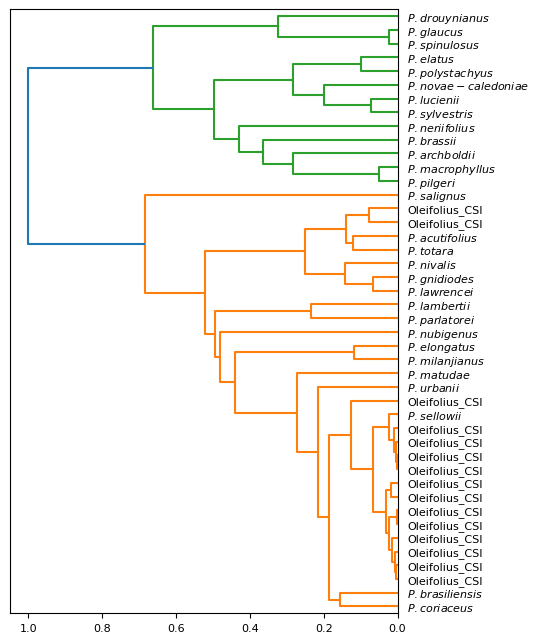

In [187]:
# Pass infividual cross-sectional images to trained MLP 

import torch
import pandas as pd

X_train_pseudonovel = torch.tensor(Concatenated_Modalities_Informative_Stacks)
X_train_novel= X_train_pseudonovel
print(X_train_pseudonovel.shape)
Genus_List_With_Pseudonovel = GenusList + ["Oleifolius_CSI",]*len(Concatenated_Modalities_Informative_Stacks)

len(Genus_List_With_Pseudonovel)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train_novel = X_train_novel.to(device)
output = best_model(X_train.float())
output_novel = best_model(X_train_novel.reshape(X_train_novel.shape[0],1,X_train_novel.shape[1]).float())
output_novel.shape
Dataset_With_Known_And_Novel = torch.vstack((output, output_novel))
Dataset_With_Known_And_Novel.shape

# k + n scheme
# Average all features per known species

Species_Index = Y;
NumericSpeciesIndex = pd.to_numeric(Species_Index);
Indices_and_Features = np.column_stack((NumericSpeciesIndex, output.cpu().detach().numpy()));
df = pd.DataFrame(data=Indices_and_Features)
Per_Species_Transformed_Features = df.groupby([0,]).mean()
Per_Species_Transformed_Features;

NumericSpeciesIndexNovel  = ["Oleifolius_CSI",]*len(Concatenated_Modalities_Informative_Stacks)

Indices_and_Features_Novel = np.column_stack((NumericSpeciesIndexNovel, output_novel.cpu().detach().numpy()));
df_novel = pd.DataFrame(data= Indices_and_Features_Novel)
df_novel.groupby(by=0,axis = 0)

df_known_averaged_and_Novel = pd.concat([Per_Species_Transformed_Features,df_novel])
df_known_averaged_and_Novel  = df_known_averaged_and_Novel.iloc[: , 1:]

#  Obtain predicted cladogram (phylogenetic tree) with the placement of the pseudo-novel specimens 
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

df_known_averaged_and_Novel_norm = (df_known_averaged_and_Novel-df_known_averaged_and_Novel.min())/(df_known_averaged_and_Novel.max()-df_known_averaged_and_Novel.min())
linked = linkage(df_known_averaged_and_Novel, "average", metric = "cosine")

Genera = ["$\it{P. acutifolius}$","$\it{P. archboldii}$","$\it{P. brasiliensis}$","$\it{P. brassii}$","$\it{P. coriaceus}$","$\it{P. drouynianus}$","$\it{P. elatus}$","$\it{P. elongatus}$","$\it{P. glaucus}$","$\it{P. gnidiodes}$","$\it{P. lambertii}$","$\it{P. lawrencei}$","$\it{P. lucienii}$","$\it{P. macrophyllus}$","$\it{P. matudae}$","$\it{P. milanjianus}$","$\it{P. neriifolius}$","$\it{P. nivalis}$","$\it{P. novae-caledoniae}$","$\it{P. nubigenus}$","$\it{P. parlatorei}$","$\it{P. pilgeri}$","$\it{P. polystachyus}$","$\it{P. salignus}$","$\it{P. sellowii}$","$\it{P. spinulosus}$","$\it{P. sylvestris}$","$\it{P. totara}$","$\it{P. urbanii}$"] + ["Oleifolius_CSI",]*len(Concatenated_Modalities_Informative_Stacks);

labelList = Genera
plt.figure(figsize=(5, 8), dpi = 100)
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
dendrogram(linked,
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.savefig("P.oleifolius_placement.pdf", bbox_inches = "tight")

In [188]:
# Compute and save cosine dissimilarity matrix as csv file. This matrix depicts distances separating the pseudo-novel specimens from the known taxa.
Feature_Matrix_Known_and_Unknown = np.array(df_known_averaged_and_Novel)
Feature_Matrix_Known_and_Unknown = Feature_Matrix_Known_and_Unknown.astype(float)
Feature_Matrix_Known_and_Unknown = torch.tensor(Feature_Matrix_Known_and_Unknown)
Feature_Matrix_Known_and_Unknown_dist = 1-sim_matrix(Feature_Matrix_Known_and_Unknown,Feature_Matrix_Known_and_Unknown)
#np.savetxt(absolute_path + "/dist_matrix_informative_CSI_oleifolius.csv", Feature_Matrix_Known_and_Unknown_dist, delimiter=",")

In [230]:
# Retrieve index of true sister taxon 
sister_taxon_index = Genera.index("$\it{P. urbanii}$")

In [529]:
# Retrieve (1) pseudo-novel rows and (2) sister taxon column from the rest of the distance matrix
pseudo_novel_rows = df_Feature_Matrix_Known_and_Unknown_dist.tail(len(Concatenated_Modalities_Informative_Stacks))
pseudo_novel_and_sister_taxon_dist = pseudo_novel_rows.iloc[:,sister_taxon_index]

In [555]:
print(pseudo_novel_and_sister_taxon_dist)

29    0.155341
30    0.190008
31    0.155904
32    0.203007
33    0.196039
34    0.218436
35    0.322359
36    0.240614
37    0.203961
38    0.222762
39    0.421077
40    0.526428
41    0.213894
42    0.197166
43    0.186090
Name: 28, dtype: float64


In [554]:
#import glob
#images = glob.glob(absolute_path + '/Oleifolius/Pseudonovel_Stacks_Oleifolius/oleifolius/oleifolius.01/*.png')

In [556]:
# Rank individual cross-sectional images according to their distance to their true sister taxon 
#pseudo_novel_and_sister_taxon_dist = np.array(pseudo_novel_and_sister_taxon_dist)
#sort_index = np.argsort(pseudo_novel_and_sister_taxon_dist)

In [336]:
k = 3; 
# Get indices of top-k most informative cross-sectional images (closest to sister taxon)
pseudo_novel_and_sister_taxon_dist = np.array(pseudo_novel_and_sister_taxon_dist)
most_informative = (pseudo_novel_and_sister_taxon_dist).argsort()[:k]
# Get indices of top-k least informative cross-sectional images (farthest from sister taxon)
least_informative = (-pseudo_novel_and_sister_taxon_dist).argsort()[:k]
print(most_informative)
print(least_informative)

[ 0  2 14]
[11 10  6]


In [507]:
from heapq import nlargest
from heapq import nsmallest 

# Return top-k smallest distances
k = 3 
smallest_k_distances = nsmallest(k, pseudo_novel_and_sister_taxon_dist)
smallest_k_distances = np.around(smallest_three_distances, decimals=4, out=None)

largest_k_distances = nlargest(k,pseudo_novel_and_sister_taxon_dist)
largest_k_distances = np.around(largest_three_distances, decimals=4, out=None)

In [ ]:
from PIL import Image

image = Image.open("C:/Users/meada/OneDrive/Desktop/New_Visualization_Folder_Bombacoideae/Sclpraecox/pseudoStacks/Sclmicranthum/Sclmicranthum.Sclpraecox.03/Scleronema_praecox10_Out_G1_09.png")
sunset_resized = image.resize((224, 224))
sunset_resized 

# Display top-k most/least informative cross-sectional images

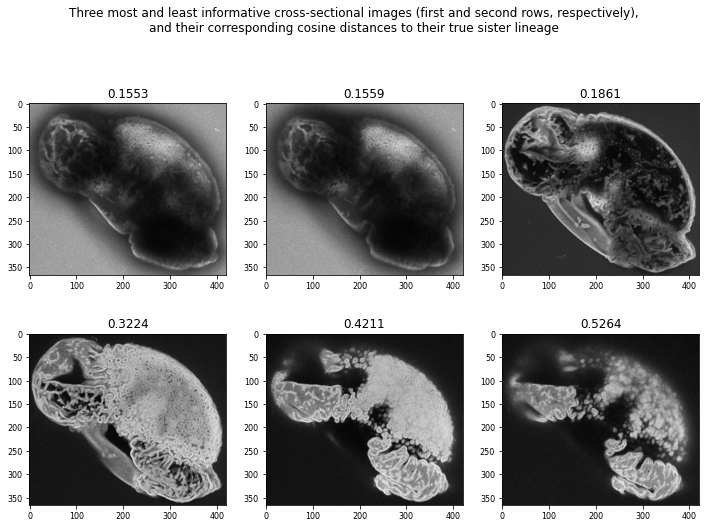

<Figure size 432x288 with 0 Axes>

In [596]:
import matplotlib.pyplot as plt
w = 10
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 3
rows = 3

plt.subplot(rows, cols, 1)
plt.imshow(imread(data_path[0]))
plt.title(smallest_k_distances[0])
plt.subplot(rows, cols, 2)
plt.imshow(imread(data_path[2]))
plt.title(smallest_k_distances[1])
plt.subplot(rows, cols, 3)
plt.imshow(imread(data_path[14]))
plt.title(smallest_k_distances[2])
plt.subplot(rows, cols, 4)
plt.imshow(imread(data_path[6]))
plt.title(largest_k_distances[2])
plt.subplot(rows, cols, 5)
plt.imshow(imread(data_path[10]))
plt.title(largest_k_distances[1])
plt.subplot(rows, cols, 6)
plt.imshow(imread(data_path[11]))
plt.title(largest_k_distances[0])
fig.suptitle('Three most and least informative cross-sectional images (first and second rows, respectively),\nand their corresponding cosine distances to their true sister lineage', fontsize = 12) 
plt.show()
fig = plt.figure()